# L-DED Audiovisual Fusion 

Author: Chen Lequn.
Created on 01 Feb 2023.

- Material： Maraging Steel 300
- Process: Robotic Llser-directed energy deposition
- Experiment number (single bead wall samples): 21-26
- Recorded data: position, veolocity, coaxial melt pool images, acoustic data
- Defect generated: keyhole pores, cracks, defect-free

### Notebook 4: Audiovisual fusion - baseline

- Testing on audio visual fusion with VGG-ish CNN model.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.multiprocessing as mp

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

import os
import argparse
from torch.utils.data import Subset
import pandas as pd
import numpy as np

# Scikit learn
#from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle, resample, class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from vision_models import * 
from audiovisual_models import *
from multimodaldataset import MultimodalDataset, LDEDAudioDataset, LDEDVisionDataset
from utils import *
from train_utils import train_single_epoch, test_single_epoch, training_loop

from torchviz import make_dot

## plot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
%matplotlib inline
import seaborn as sns

np.random.seed(0)
torch.manual_seed(0)

In [11]:
def get_sample_directories_from_df(df, Dataset_path):
    # Extract unique sample numbers from the DataFrame
    unique_sample_numbers = df['Sample number'].unique()
    
    # Generate the full paths for image and audio directories
    image_directories = [os.path.join(Dataset_path, str(sample_number), 'images') for sample_number in unique_sample_numbers]
    audio_directories = [os.path.join(Dataset_path, str(sample_number), 'raw_audio') for sample_number in unique_sample_numbers]
    
    return image_directories, audio_directories

samples = [21, 22, 23, 24, 26, 32]
image_directories, audio_directories = get_sample_directories_from_df(df_multimodal, Dataset_path)
image_directories

['/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/21/images',
 '/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/22/images',
 '/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/23/images',
 '/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/24/images',
 '/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/26/images']

In [4]:
# classes = ('Laser-off', 'Defect-free', 'Defective')
classes = ('Laser-off', 'Defect-free', 'Cracks', "Keyhole pores")
classes = ('Defect-free', 'Keyhole pores', 'Laser defocus', 'Laser-off')


SAMPLE_RATE = 44100
LEARNING_RATE = 0.00001
BATCH_SIZE = 32
EPOCHS = 10

### Utils functions

In [5]:
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'defect classification', 'class_name_v3','audio_visual_cnn')
os.makedirs(IMAGE_PATH, exist_ok=True)

model_path = os.path.join(PROJECT_ROOT_DIR, "trained_models", 'defect classification', 'class_name_v3', 'audio_visual_cnn')

Multimodal_dataset_PATH = "/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset"
Dataset_path = os.path.join(Multimodal_dataset_PATH, f'25Hz')

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

### Use GPU if possible

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")
# mp.set_start_method("spawn")
mp.set_start_method(method='forkserver', force=True)

Using cuda


### Annotation file

- Vision acoustic spatio-temporal registration has been done in our previous work. 
- Each frame (timestamp) corresponds to a robot TCP position.
- The duration for each frame is 0.01 seconds (sampling freqeuncy 10 Hz.)

In [7]:
# Read the data back from the HDF5 file into a new DataFrame
df_multimodal = pd.read_hdf(os.path.join(Dataset_path, 'spatiotemporal_fused_multimodal.h5'), key='df')
df_multimodal = df_multimodal.dropna(subset=['class_name_v3'])

# Fill NaN values in 'class_name' with 'Unlabeled'
# df_multimodal['class_name'] = df_multimodal['class_name'].astype(str)
# df_multimodal['class_name'].fillna('Unlabeled', inplace=True)
df_multimodal

,sample index,Time_Stamps,audio_file_name,image_file_name,class_name,class_name_v2,Layer number,Sample number,class_name_v3,rms_energy,...,center_y,contour_area,contour_length,X,Y,Z,Vx,Vy,Vz,Speed
0,1,0.00,sample_21_1.wav,sample_21_1.jpg,Laser-off,Laser-off,1.0,21,Laser-off,0.009018,...,0.000000,0.0,0.000000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000
1,2,0.04,sample_21_2.wav,sample_21_2.jpg,Defect-free,Defect-free,1.0,21,Defect-free,0.019286,...,239.000000,305442.0,2234.000000,0.000,-0.000,0.001,-0.074,-0.074,0.000,0.105
2,3,0.08,sample_21_3.wav,sample_21_3.jpg,Defect-free,Defect-free,1.0,21,Defect-free,0.019593,...,239.000000,305442.0,2234.000000,-0.010,0.015,-0.007,-0.051,0.026,-0.051,0.077
3,4,0.12,sample_21_4.wav,sample_21_4.jpg,Defect-free,Defect-free,1.0,21,Defect-free,0.030937,...,230.264496,291865.5,2279.781744,-0.007,0.016,0.010,0.173,-0.222,2.520,2.536
4,5,0.16,sample_21_5.wav,sample_21_5.jpg,Defect-free,Defect-free,1.0,21,Defect-free,0.038329,...,229.109962,281970.0,2407.847760,-0.111,0.123,-0.057,-1.864,1.662,-2.468,3.511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48461,10982,439.24,sample_26_10982.wav,sample_26_10982.jpg,Laser-off,Laser-off,NaN,26,Laser-off,0.011000,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080
48462,10983,439.28,sample_26_10983.wav,sample_26_10983.jpg,Laser-off,Laser-off,NaN,26,Laser-off,0.008347,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080
48463,10984,439.32,sample_26_10984.wav,sample_26_10984.jpg,Laser-off,Laser-off,NaN,26,Laser-off,0.011081,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080
48464,10985,439.36,sample_26_10985.wav,sample_26_10985.jpg,Laser-off,Laser-off,NaN,26,Laser-off,0.011044,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080


In [8]:
# Get the labels and count the number of samples for each class
labels = df_multimodal['class_name_v3'].values
label_counts = np.unique(labels, return_counts=True)[1]
print (label_counts)

[ 7601  4991  6208 17757]


In [9]:
df_multimodal.iloc[1300,0]

1422

### Basline accuracy
The baseline accuracy in this multi-class classificiation problem is **53%**, which is the accuracy of trivially predicting the most-frequent class (classify to the largest class– in other words).

In [12]:
### Get the percentage distribution of each category
round(df_multimodal.groupby('class_name_v3')["class_name_v3"].count()/df_multimodal.shape[0]*100, 1)

class_name_v3
Defect-free      20.8
Keyhole pores    13.7
Laser defocus    17.0
Laser-off        48.6
Name: class_name_v3, dtype: float64

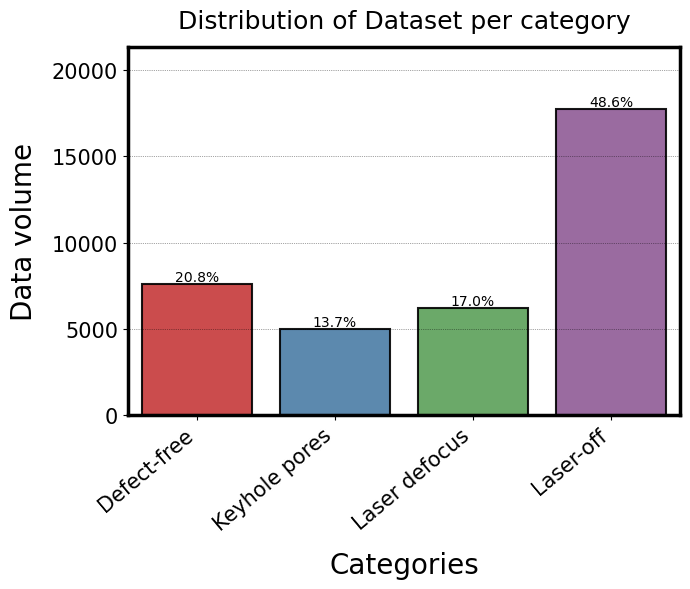

In [13]:
plot_data_distribution(df_multimodal, 'class_name_v3', 
                       'Distribution of Dataset per category', 'dataset_distribution')

## Preparing Dataset and DataLoader

Mean: 76.93087324120341

Standard Deviation: 71.49791275013504

In [14]:
#------ transformation------
visual_train_transforms=transforms.Compose([
    torchvision.transforms.Resize((32,32)), # original image size: (640,480)
    transforms.RandomHorizontalFlip(),  # data augmentation
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=90),
    transforms.ToTensor(),
    transforms.Normalize(mean=[76.93087324120341], std=[71.49791275013504]),
])

visual_val_transforms=transforms.Compose([
    torchvision.transforms.Resize((32,32)), # original image size: (640,480)
    transforms.ToTensor(),
    transforms.Normalize(mean=[76.93087324120341], std=[71.49791275013504]),
])

visual_test_transforms=transforms.Compose([
    torchvision.transforms.Resize((32,32)), # original image size: (640,480)
    transforms.ToTensor(),
    transforms.Normalize(mean=[76.93087324120341], std=[71.49791275013504]),
])

#------ audio transfomation------
# instantiating our dataset object and create data loader
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=512,
    hop_length=256,
    n_mels=32
)

MFCCs = torchaudio.transforms.MFCC(sample_rate=SAMPLE_RATE,n_mfcc=20)

/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [16]:
#------ data loader------
# create the dataset for all samples

mmd = MultimodalDataset(df_multimodal,
                        image_directories,
                        audio_directories,
                        samples,
                        visual_train_transforms,
                        mel_spectrogram,
                        SAMPLE_RATE,
                        device)

print ("length of the total dataset:" + str(len(mmd)))

length of the total dataset:36557


## Train Val Test dataset 

- Split the data into train, validation, and test set
- Train and Val are used for hyperparameter tuning
- Train set will go through some data augmentation

In [17]:
%store -r train_indices
%store -r val_indices
%store -r test_indices

In [18]:
# Create train, val, and test datasets for deep learning models
train_annotations = df_multimodal.iloc[train_indices, :]
val_annotations = df_multimodal.iloc[val_indices, :]
test_annotations = df_multimodal.iloc[test_indices, :]

train_dataset = MultimodalDataset(train_annotations, image_directories, audio_directories, samples, visual_train_transforms, mel_spectrogram, SAMPLE_RATE, device=device)
val_dataset = MultimodalDataset(val_annotations, image_directories, audio_directories, samples, visual_val_transforms, mel_spectrogram, SAMPLE_RATE, device=device)
test_dataset = MultimodalDataset(test_annotations, image_directories, audio_directories, samples, visual_test_transforms, mel_spectrogram, SAMPLE_RATE, device=device)

### Create DataLoader using the dataset

In [19]:
# # Create train and val dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=6)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print("length of the train dataset:" +  str(len(train_dataloader.dataset)))
print("length of the val dataset:" +  str(len(val_dataloader.dataset)))
print("length of the test dataset:" +  str(len(test_dataloader.dataset)))

length of the train dataset:29245
length of the val dataset:3656
length of the test dataset:3656


## Training the model

In [20]:
resume = False
start_epoch = 0
best_acc = 0

In [21]:
# -----Model---------------
print('==> Building model..')

net = AudioVisualFusionCNN() 

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    print ("--- Using CUDA ---")

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

loss_fn = nn.CrossEntropyLoss()
# Note: weight_decay in pytorch is L2 regularization
# optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE,
#                     momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=5e-3) ## consider AdamW
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


model, optimizer, (train_losses, valid_losses, train_accuracy, valid_accuracy) = training_loop(net, loss_fn, optimizer,
                                                                                               train_dataloader, val_dataloader, EPOCHS, 
                                                                                               scheduler, device, mode = "multi_model")

==> Building model..
--- Using CUDA ---

Epoch: 0


Epoch 0:   0%|                      | 0/115 [00:18<?, ?it/s, loss=0.896, accuracy=85]


09:47:51 --- Epoch: 0	Train loss: 0.9609	Valid loss: 0.0282	Train accuracy: 79.03	Valid accuracy: 84.96

Epoch: 1


Epoch 1:   0%|                    | 0/115 [00:18<?, ?it/s, loss=0.861, accuracy=88.7]


09:49:25 --- Epoch: 1	Train loss: 0.8734	Valid loss: 0.0271	Train accuracy: 87.72	Valid accuracy: 88.68

Epoch: 2


Epoch 2:   0%|                    | 0/115 [00:18<?, ?it/s, loss=0.858, accuracy=88.7]


09:50:52 --- Epoch: 2	Train loss: 0.8602	Valid loss: 0.0270	Train accuracy: 88.63	Valid accuracy: 88.68

Epoch: 3


Epoch 3:   0%|                    | 0/115 [00:18<?, ?it/s, loss=0.844, accuracy=89.7]


09:52:18 --- Epoch: 3	Train loss: 0.8543	Valid loss: 0.0265	Train accuracy: 89.02	Valid accuracy: 89.74

Epoch: 4


Epoch 4:   0%|                     | 0/115 [00:18<?, ?it/s, loss=0.84, accuracy=90.3]


09:53:43 --- Epoch: 4	Train loss: 0.8465	Valid loss: 0.0264	Train accuracy: 89.95	Valid accuracy: 90.32

Epoch: 5


Epoch 5:   0%|                    | 0/115 [00:18<?, ?it/s, loss=0.854, accuracy=88.5]


09:55:09 --- Epoch: 5	Train loss: 0.8439	Valid loss: 0.0269	Train accuracy: 89.99	Valid accuracy: 88.51

Epoch: 6


Epoch 6:   0%|                    | 0/115 [00:18<?, ?it/s, loss=0.837, accuracy=90.7]


09:56:35 --- Epoch: 6	Train loss: 0.8428	Valid loss: 0.0263	Train accuracy: 90.17	Valid accuracy: 90.67

Epoch: 7


Epoch 7:   0%|                    | 0/115 [00:18<?, ?it/s, loss=0.857, accuracy=89.4]


09:58:01 --- Epoch: 7	Train loss: 0.8409	Valid loss: 0.0270	Train accuracy: 90.27	Valid accuracy: 89.39

Epoch: 8


Epoch 8:   0%|                     | 0/115 [00:18<?, ?it/s, loss=0.85, accuracy=89.1]


09:59:29 --- Epoch: 8	Train loss: 0.8412	Valid loss: 0.0267	Train accuracy: 90.25	Valid accuracy: 89.14

Epoch: 9


Epoch 9:   0%|                       | 0/115 [00:18<?, ?it/s, loss=0.86, accuracy=88]

10:00:55 --- Epoch: 9	Train loss: 0.8394	Valid loss: 0.0271	Train accuracy: 90.37	Valid accuracy: 88.05


In [22]:
valid_accuracy

[84.9562363238512,
 88.67614879649891,
 88.67614879649891,
 89.74288840262582,
 90.31728665207878,
 88.51203501094092,
 90.67286652078775,
 89.38730853391685,
 89.14113785557987,
 88.04704595185996]

Saving figure loss_accuracy_curve_multimodal


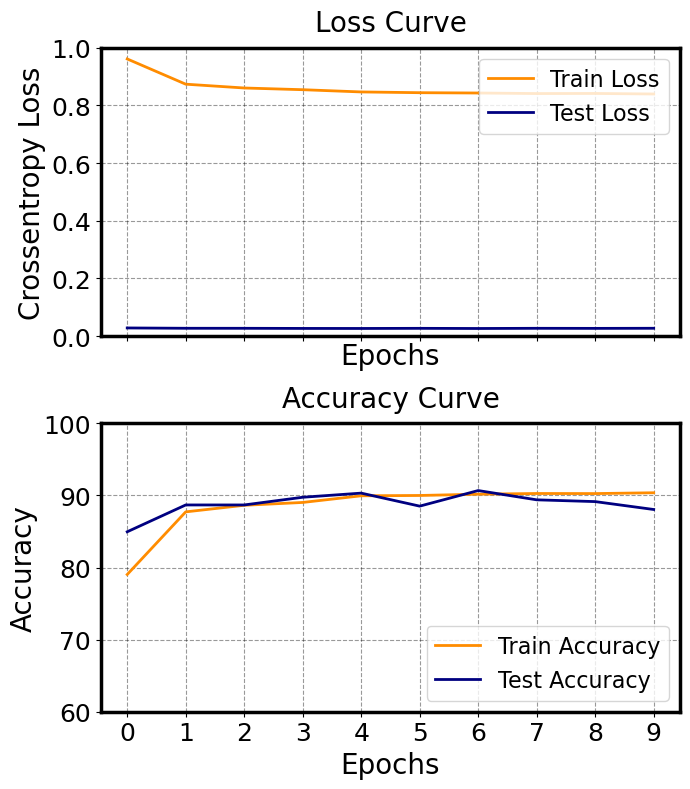

In [28]:
loss_acc_plot(train_losses, valid_losses, train_accuracy, valid_accuracy, 9, "Initial Training",
              interval=1, yloss_limit1=0, yloss_limit2=1.0, yacc_limit1=60, yacc_limit2=100)

save_fig ("loss_accuracy_curve_multimodal")

In [23]:
get_accuracy(model, val_dataloader, device, mode = 'multi_model')

0.8804704595185996

Test Accuracy (cross-validation) for Hybrid-CNN = 0.88047 ± 0.01132
micro-averaging AUC for Hybrid-CNN = 0.97208 ± 0.00000
Saving figure ROC_curve (multimodal_fusion-based)


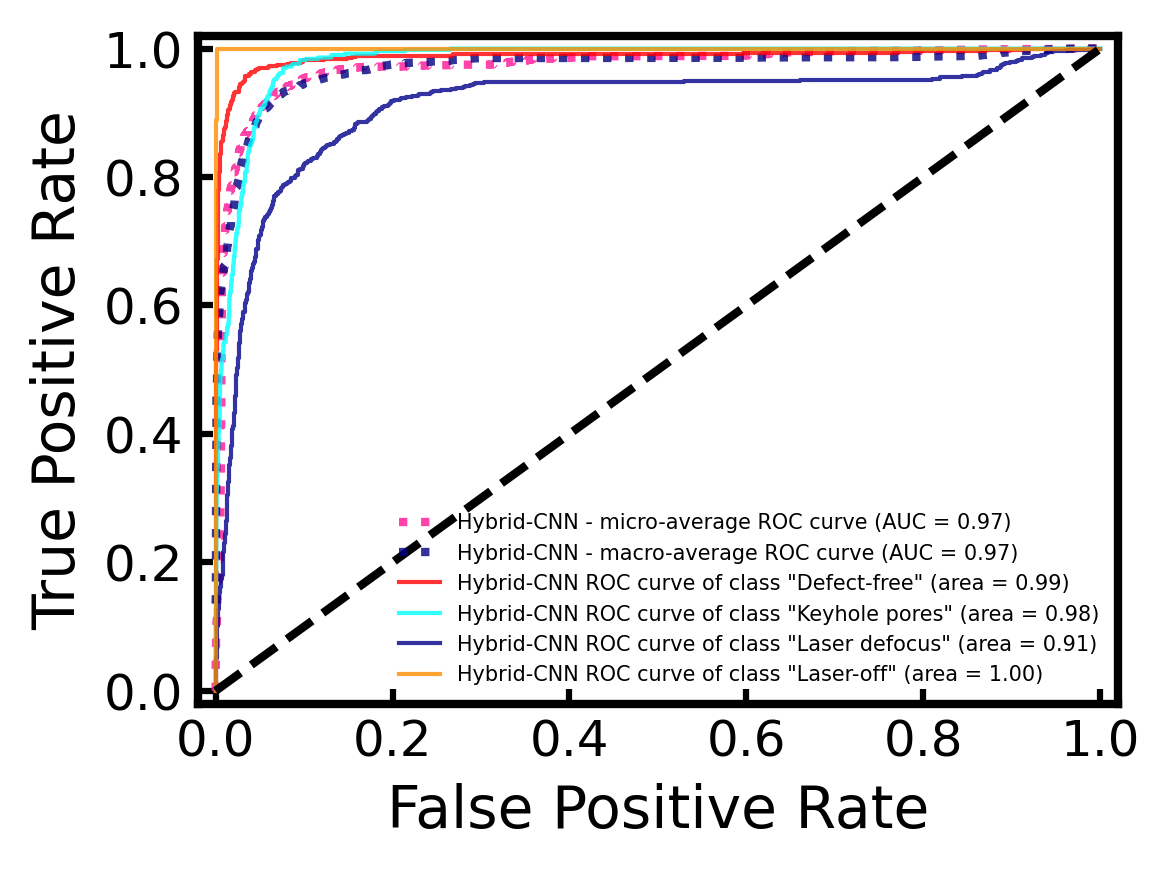

In [24]:
test_accuracy_mean, test_accuracy_std, auc_mean, auc_std = model_evaluation(model, val_dataloader, classes, device, classifier_name = "Hybrid-CNN",
                                                                            signal_type = "raw", seed=0, mode = 'multi_model')

save_fig ("ROC_curve (multimodal_fusion-based)")

In [25]:
yt, yp = class_report(model, val_dataloader, device, classes, mode="multi_model")

               precision    recall  f1-score   support

  Defect-free     0.9593    0.8684    0.9116       760
Keyhole pores     0.5944    0.9840    0.7411       499
Laser defocus     0.8043    0.4767    0.5986       621
    Laser-off     0.9989    0.9977    0.9983      1776

     accuracy                         0.8805      3656
    macro avg     0.8392    0.8317    0.8124      3656
 weighted avg     0.9024    0.8805    0.8773      3656



[[ 660   34   64    2]
 [   0  491    8    0]
 [  26  299  296    0]
 [   2    2    0 1772]]
Saving figure confusion_matrix(audio_visual)


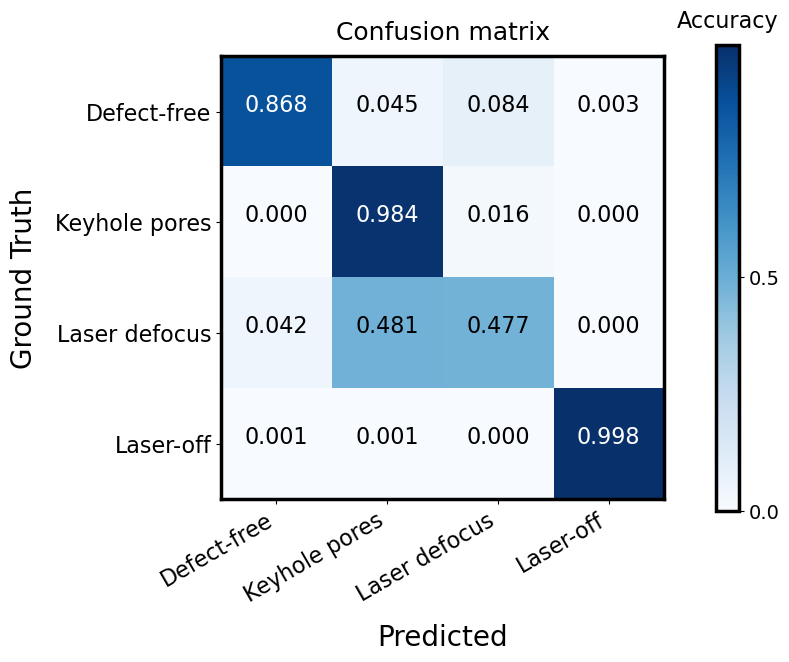

In [26]:
conf_matrix(yt, yp, classes)
save_fig("confusion_matrix(audio_visual)")

In [27]:
model = AudioVisualFusionCNN()
image = torch.randn(1, 1, 32, 32)
audio = torch.randn(1, 1, 32, 7)
predictions = model(image, audio)
# make_dot(predictions.mean(), params=dict(model.named_parameters()))
# make_dot(predictions)
# save_fig("multimodal_structure")
# make_dot(predictions.mean(), params=dict(model.named_parameters()),show_attrs=True, show_saved=True)